In [1]:
from sqlalchemy import create_engine

In [2]:
import pandas as pd

In [ ]:
connection credentials / configuration parameters.

In [ ]:
connection_string = (
    "mssql+pyodbc://connection credentials / configuration parameters.?"
    "driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes"
)

In [5]:
engine = create_engine(connection_string)

In [6]:
query= "select * from PickUpLines"

In [7]:
df = pd.read_sql(query, engine)

In [8]:
data= pd.read_sql(query,engine)

In [10]:
df.describe()

,ParticipantNumber,PickUp,Scent,Receptivity,Gender,Age,Ethnicity,YearInSchool,Contraceptive
count,194.000000,194.000000,194.000000,194.000000,194.0,194.000000,194.000000,194.000000,194.000000
mean,97.500000,1.381443,1.463918,3.783719,2.0,20.278351,3.103093,1.783505,1.381443
std,56.147128,0.486998,0.499987,0.530932,0.0,2.179710,1.212923,0.764860,0.486998
min,1.000000,1.000000,1.000000,2.403700,2.0,19.000000,1.000000,1.000000,1.000000
25%,49.250000,1.000000,1.000000,3.374425,2.0,19.000000,2.000000,1.000000,1.000000
50%,97.500000,1.000000,1.000000,3.734980,2.0,20.000000,4.000000,2.000000,1.000000
75%,145.750000,2.000000,2.000000,4.104780,2.0,21.000000,4.000000,2.000000,2.000000
max,194.000000,2.000000,2.000000,5.000000,2.0,39.000000,5.000000,4.000000,2.000000


In [11]:
# Checking for significant outliers.

import numpy as np
from scipy.stats import chi2

In [12]:
X = df[["PickUp", "Scent"]].values
mean = np.mean(X, axis=0)
cov = np.cov(X, rowvar=False)
inv_cov = np.linalg.inv(cov)

In [13]:
# Mahalanobis distance
distances = []
for x in X:
    d = np.sqrt((x - mean).T @ inv_cov @ (x - mean))
    distances.append(d)

df["mahalanobis"] = distances

In [14]:
# Threshold (99% confidence)
threshold = np.sqrt(chi2.ppf(0.99, df=2))

outliers = df[df["mahalanobis"] > threshold]
print(outliers)

Empty DataFrame
Columns: [ParticipantNumber, PickUp, Scent, Receptivity, Gender, Age, Ethnicity, YearInSchool, Contraceptive, mahalanobis]
Index: []


In [15]:
# The results indicate the absence of significant outliers

In [16]:
# Assessing normality across groups

from scipy.stats import shapiro

In [17]:
for (pickup, scent), group in df.groupby(["PickUp", "Scent"]):
    if len(group) >= 3:   # Shapiro requires at least 3 observations
        stat, p = shapiro(group["Receptivity"])
        print(
            f"PickUp={pickup}, Scent={scent}: "
            f"n={len(group)}, W={stat:.4f}, p={p:.4f}"
        )
    else:
        print(
            f"PickUp={pickup}, Scent={scent}: "
            f"n={len(group)} → not enough data for Shapiro"
        )

PickUp=1, Scent=1: n=60, W=0.9472, p=0.0115
PickUp=1, Scent=2: n=60, W=0.9624, p=0.0616
PickUp=2, Scent=1: n=44, W=0.9590, p=0.1198
PickUp=2, Scent=2: n=30, W=0.9660, p=0.4355


In [18]:
# Based on the above results, the group 'PickUp=1, Scent=1' (n=60, W=0.9472, p=0.0115) does not follow a normal distribution; however, the p-value is not extreme and the deviation from normality can still be considered acceptable.

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

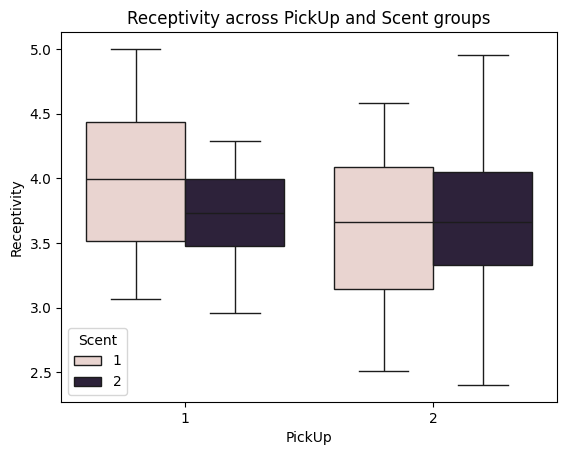

In [22]:
sns.boxplot(
    x="PickUp",
    y="Receptivity",
    hue="Scent",
    data=df
)
plt.title("Receptivity across PickUp and Scent groups")
plt.show()

In [23]:
import scipy.stats as stats

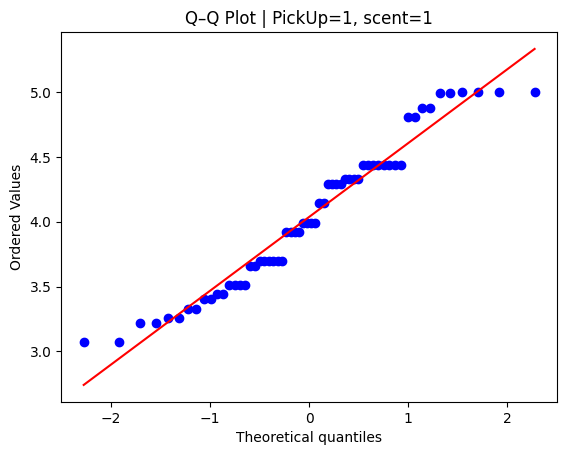

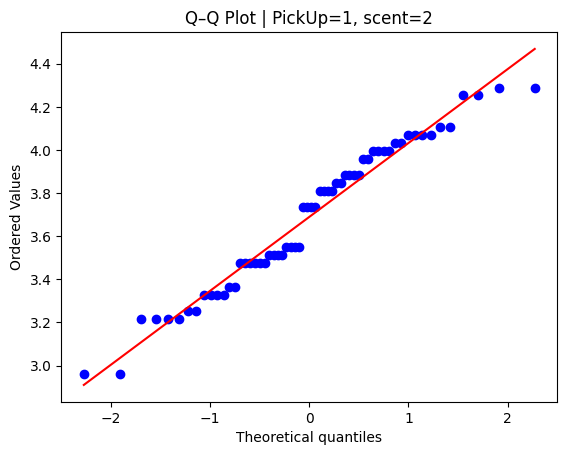

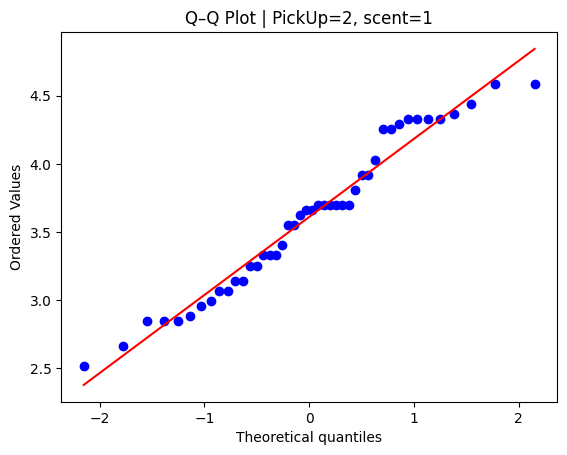

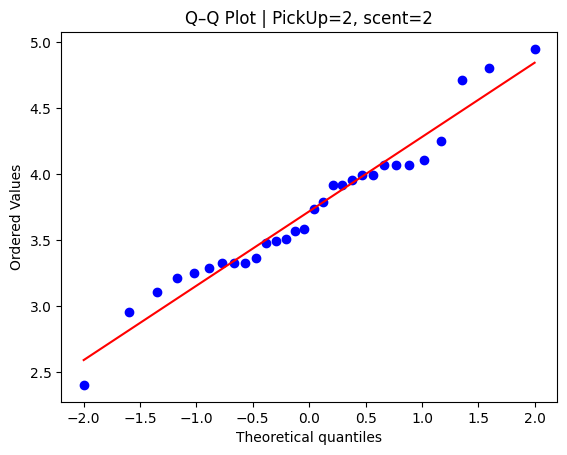

In [25]:
groups = df.groupby(["PickUp", "Scent"])

for (pickup, scent), group in groups:
    if len(group) >= 3:
        stats.probplot(group["Receptivity"], plot=plt)
        plt.title(f"Q–Q Plot | PickUp={pickup}, scent={scent}")
        plt.show()

In [26]:
# Assessing homogeneity of variance (Levene’s test, p > 0.05)

from scipy.stats import levene

In [27]:
# Homogeneity across pickup and scent groups

groups = [
    group["Receptivity"].values
    for _, group in df.groupby(["PickUp", "Scent"])
    if len(group) > 1
]

stat, p = levene(*groups, center="median")
print(f"Levene (PickUp × Scent): W={stat:.4f}, p={p:.4f}")

Levene (PickUp × Scent): W=5.5293, p=0.0012


In [28]:
# Based on this result ('Levene (PickUp × Scent): W = 5.5293, p = 0.0012'), the variances are heterogeneous

In [29]:
# Due to the unequal variances, I performed a robust heteroscedastic two-way ANOVA.

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [31]:
# Treat factors as categorical

df["PickUp"] = df["PickUp"].astype("category")
df["Scent"] = df["Scent"].astype("category")

In [32]:
# Fit two-way model with interaction

model = smf.ols(
    "Receptivity ~ C(PickUp) * C(Scent)",
    data=df
).fit(cov_type="HC3")   # HC3 = robust to heteroscedasticity

In [33]:
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                       sum_sq     df         F    PR(>F)
C(PickUp)            1.535423    1.0  6.007512  0.015150
C(Scent)             2.225687    1.0  8.708244  0.003567
C(PickUp):C(Scent)   2.091678    1.0  8.183919  0.004700
Residual            48.560938  190.0       NaN       NaN


In [34]:
# Because an interaction was present, I performed post hoc testing using pg.pairwise_gameshowell on the subsets to examine simple effects

In [35]:
import pingouin as pg

In [36]:
# Ensure factors are categorical

df["PickUp"] = df["PickUp"].astype("category")
df["Scent"] = df["Scent"].astype("category")

In [37]:
# Simple effects of pickup within each scent level

for scent_level in df["Scent"].cat.categories:
    subset = df[df["Scent"] == scent_level]

    print(f"\nSimple effect of PickUp at Scent = {scent_level}")
    print(
        pg.pairwise_gameshowell(
            data=subset,
            dv="Receptivity",
            between="PickUp"
        )
    )


Simple effect of PickUp at Scent = 1
   A  B   mean(A)   mean(B)      diff        se         T         df  \
0  1  2  4.037497  3.610593  0.426904  0.112449  3.796419  93.305652   

       pval    hedges  
0  0.000261  0.746859  

Simple effect of PickUp at Scent = 2
   A  B   mean(A)   mean(B)      diff        se         T         df  \
0  1  2  3.689371  3.718778 -0.029407  0.110238 -0.266755  40.274773   

       pval    hedges  
0  0.791019 -0.068972  


In [38]:
# Simple effects of scent within each pickup level

for pickup_level in df["PickUp"].cat.categories:
    subset = df[df["PickUp"] == pickup_level]

    print(f"\nSimple effect of Scent at PickUp = {pickup_level}")
    print(
        pg.pairwise_gameshowell(
            data=subset,
            dv="Receptivity",
            between="Scent"
        )
    )


Simple effect of Scent at PickUp = 1
   A  B   mean(A)   mean(B)      diff       se         T         df      pval  \
0  1  2  4.037497  3.689371  0.348125  0.08566  4.064051  96.346064  0.000098   

     hedges  
0  0.737265  

Simple effect of Scent at PickUp = 2
   A  B   mean(A)   mean(B)      diff        se         T         df  \
0  1  2  3.610593  3.718778 -0.108185  0.132135 -0.818746  63.222905   

       pval   hedges  
0  0.416007 -0.19114  
